In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn 

from sklearn.decomposition import PCA
from xgboost import XGBClassifier

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Importing our train_set datasets
labels =  ['age', 'workclass', 'fnlwgt', 
           'education', 'educationNo', 
           'marital', 'occupation', 
           'relationship', 'race', 'sex', 
           'gain', 'loss', 
           'hoursPerWeek', 'country', 
           'income']
data_train = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, names = labels)
data_test  = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None, names = labels)

In [3]:
data_train.head()

,age,workclass,fnlwgt,education,educationNo,marital,occupation,relationship,race,sex,gain,loss,hoursPerWeek,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data_test.head()

,age,workclass,fnlwgt,education,educationNo,marital,occupation,relationship,race,sex,gain,loss,hoursPerWeek,country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


DATA ANALYSIS & CLEANING

In [5]:
data_train.replace(' ?', np.nan).dropna().shape  # Our missing rows in train_set

(30162, 15)

In [6]:
data_test.replace(' ?', np.nan).dropna().shape # Our missing rows in test_set

(15060, 15)

In [7]:
train_nomissing_data = data_train.replace('?', np.nan).dropna()
test_nomissing_data  = data_test.replace('?', np.nan).dropna()

In [8]:
#Now let target income thresholds for test_set and check if that will affect train_set features
test_nomissing_data['income'] = test_nomissing_data.income.replace({' <=50K.': ' <=50K', ' >50K.': ' >50K' })
test_nomissing_data.income.unique()

array([' <=50K', ' >50K'], dtype=object)

In [9]:
train_nomissing_data.income.unique()

array([' <=50K', ' >50K'], dtype=object)

In [10]:
#Let apply Ordinal Encoding to Categoricals instead of One-Hot-Encoding by stacking them vertically
data_mixed = pd.concat([train_nomissing_data, test_nomissing_data], axis = 0)
data_mixed.head()

,age,workclass,fnlwgt,education,educationNo,marital,occupation,relationship,race,sex,gain,loss,hoursPerWeek,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
# Remove spaces after comma for pandas convenience
data_mixed[data_mixed.select_dtypes(['object']).columns] = data_mixed.select_dtypes(['object']).apply(lambda x: x.str.strip())
data_mixed.tail()

,age,workclass,fnlwgt,education,educationNo,marital,occupation,relationship,race,sex,gain,loss,hoursPerWeek,country,income
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K
16280,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K


In [12]:
#Visualize income our prediction target.
#fig = plt.figure(figsize=(20,1.5))
#plt.style.use('seaborn-ticks')
#sns.countplot(y="income", data=data_mixed, order=data_mixed['income'].value_counts().index)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matpl

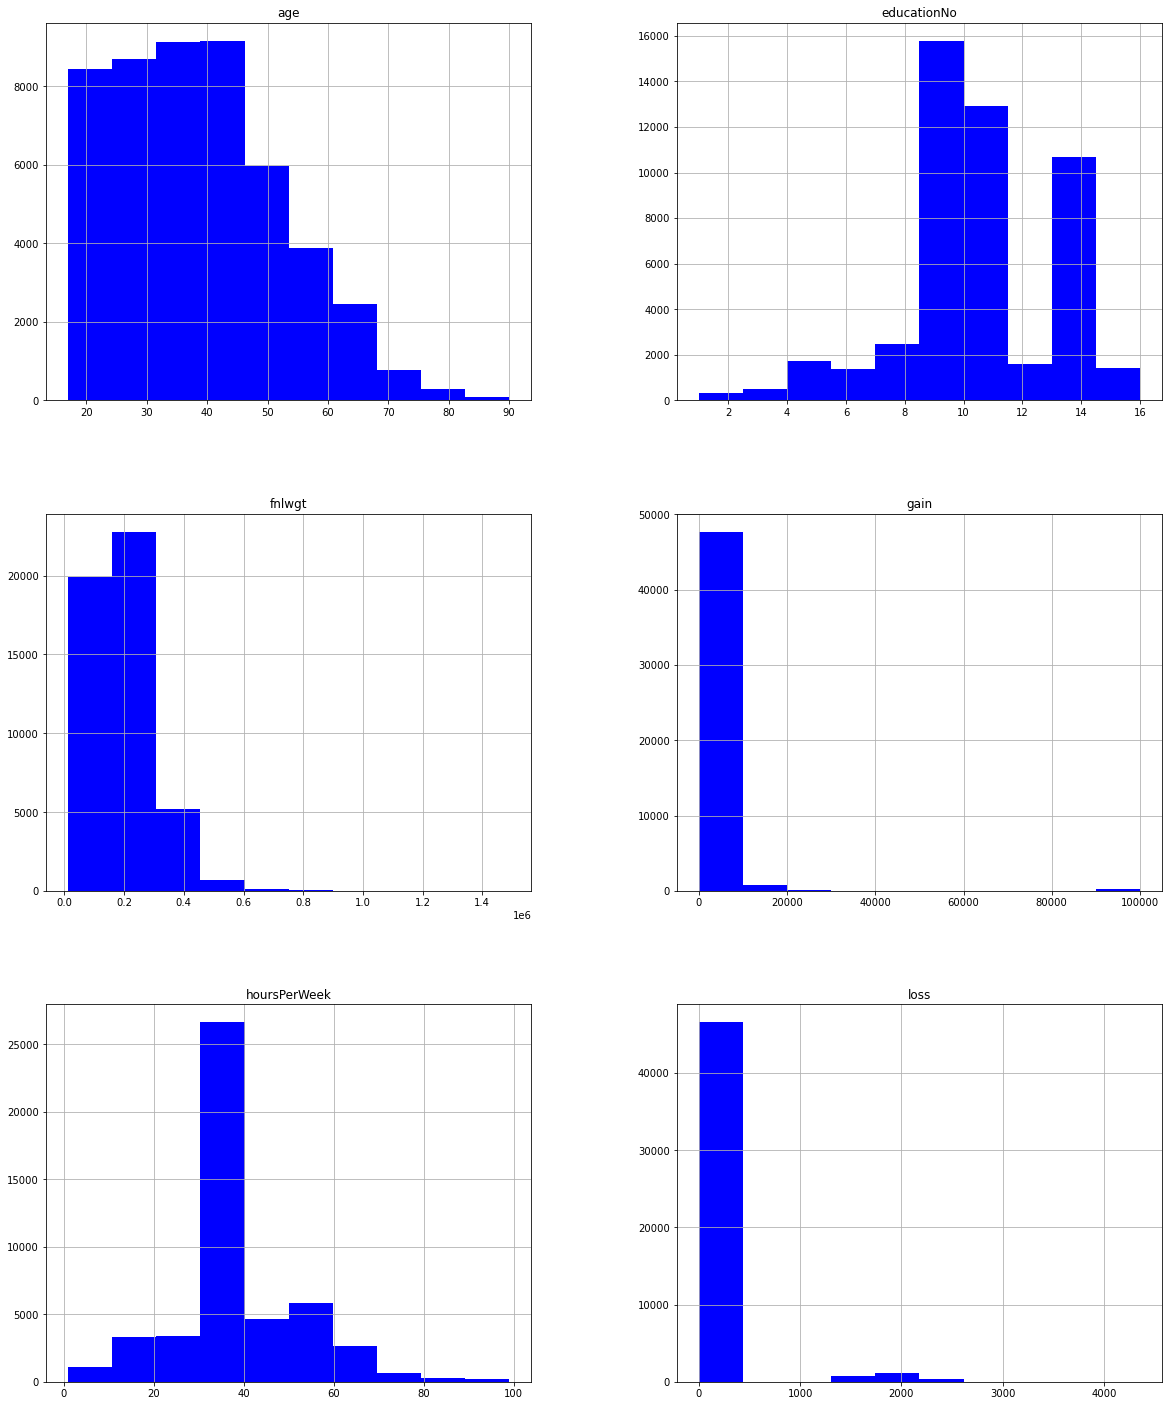

In [13]:
data_mixed.hist(figsize=(20,25), color= 'blue')
plt.show()

FEATURE ENGINEERING

In [14]:
print("---------- LET PRINT OUR FEATURES🙄 -----------")
print('1- workclass:\n',data_mixed.workclass.unique())
print("----------")
print('2- education:\n',data_mixed.education.unique())
print("----------")
print('3- marital:\n',data_mixed['marital'].unique())
print("----------")
print('4- occupation:\n',data_mixed.occupation.unique())
print("----------")
print('5- relationship:\n',data_mixed.relationship.unique())
print("----------")
print('6- race:\n',data_mixed.race.unique())
print("----------")
print('sex:\n',data_mixed.sex.unique())
print("----------")
print('7- country:\n',data_mixed['country'].unique())
print("----------")
print('8- income:\n',data_mixed.income.unique())


---------- LET PRINT OUR FEATURES🙄 -----------
1- workclass:
 ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
----------
2- education:
 ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
----------
3- marital:
 ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
----------
4- occupation:
 ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
----------
5- relationship:
 ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
----------
6- race:
 ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
----------
sex:
 ['M

In [15]:
"""Let closely analys Education and EducationalNo features.
education:
 ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
"""

data_mixed.education.replace(' Preschool', 'dropout',inplace=True)
data_mixed.education.replace(' 10th', 'dropout',inplace=True)
data_mixed.education.replace(' 11th', 'dropout',inplace=True)
data_mixed.education.replace(' 12th', 'dropout',inplace=True)
data_mixed.education.replace(' 1st-4th', 'dropout',inplace=True)
data_mixed.education.replace(' 5th-6th', 'dropout',inplace=True)
data_mixed.education.replace(' 7th-8th', 'dropout',inplace=True)
data_mixed.education.replace(' 9th', 'dropout',inplace=True)
data_mixed.education.replace(' HS-Grad', 'HighGrad',inplace=True)
data_mixed.education.replace(' HS-grad', 'HighGrad',inplace=True)
data_mixed.education.replace(' Some-college', 'CommunityCollege',inplace=True)
data_mixed.education.replace(' Assoc-acdm', 'CommunityCollege',inplace=True)
data_mixed.education.replace(' Assoc-voc', 'CommunityCollege',inplace=True)
data_mixed.education.replace(' Bachelors', 'Bachelors',inplace=True)
data_mixed.education.replace(' Masters', 'Masters',inplace=True)
data_mixed.education.replace(' Prof-school', 'Masters',inplace=True)
data_mixed.education.replace(' Doctorate', 'Doctorate',inplace=True)

In [16]:
data_mixed[['education','educationNo']].groupby(['education'], as_index=False).mean().sort_values(by='educationNo', ascending=False)

,education,educationNo
10,Doctorate,16
14,Prof-school,15
12,Masters,14
9,Bachelors,13
7,Assoc-acdm,12
8,Assoc-voc,11
15,Some-college,10
11,HS-grad,9
2,12th,8
1,11th,7


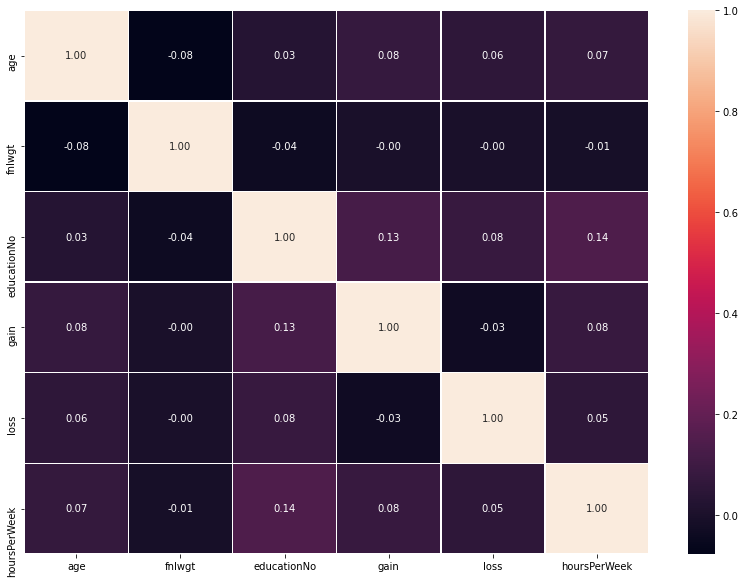

In [17]:
plt.figure(figsize=(14,10))
sns.heatmap(data_mixed.corr(),annot=True,fmt='.2f', linewidth=0.5)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2272: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='hoursPerWeek', ylabel='age'>

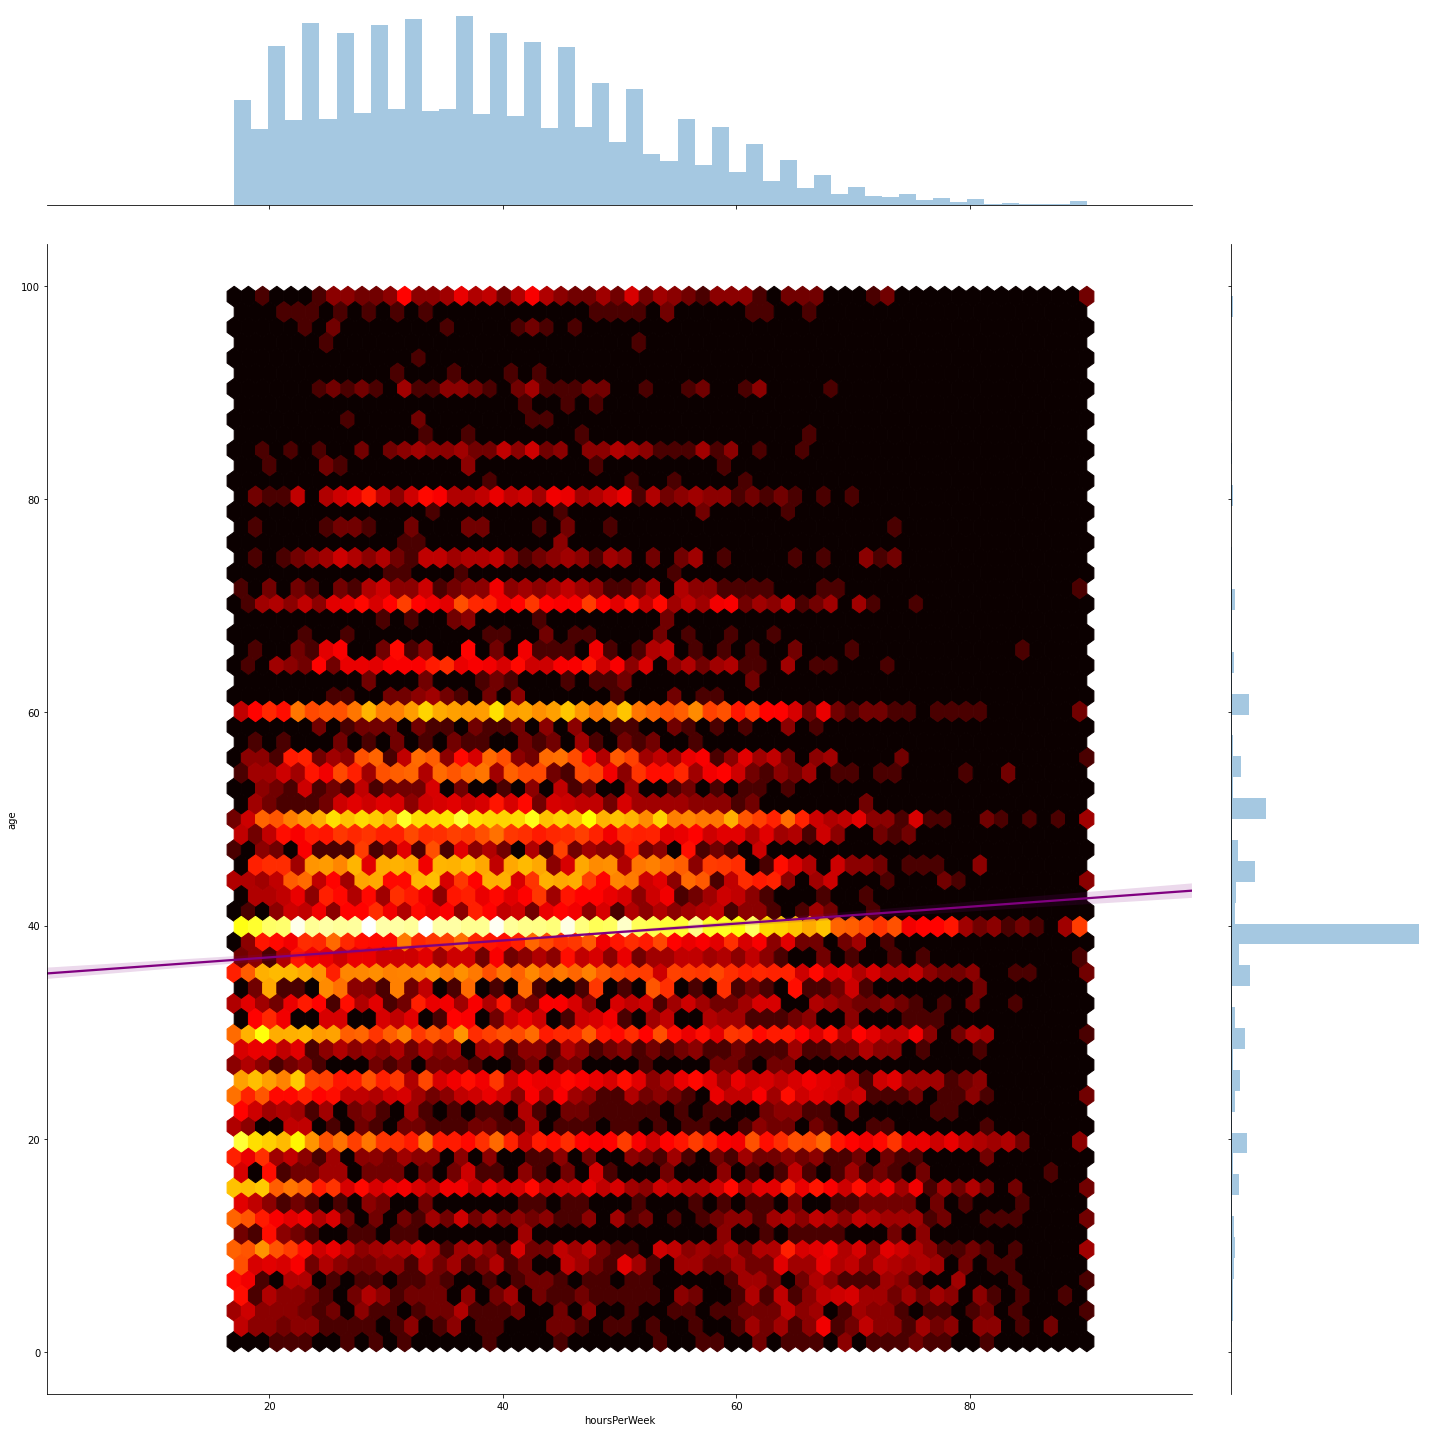

In [20]:
""" Crossing feature between Age and HoursPerWeek""" 
g = sns.jointplot(x = 'age', 
              y = 'hoursPerWeek',
              data = data_mixed, 
              kind = 'hex',
              #color="#5d5d60",
              joint_kws={'gridsize':60, 'bins':'log'},
              cmap= 'hot',
              #interpolation='nearest',
              size=20)

sns.regplot(data_mixed.hoursPerWeek, data_mixed['age'], ax=g.ax_joint, scatter=False, color='purple')

<AxesSubplot:xlabel='race', ylabel='age'>

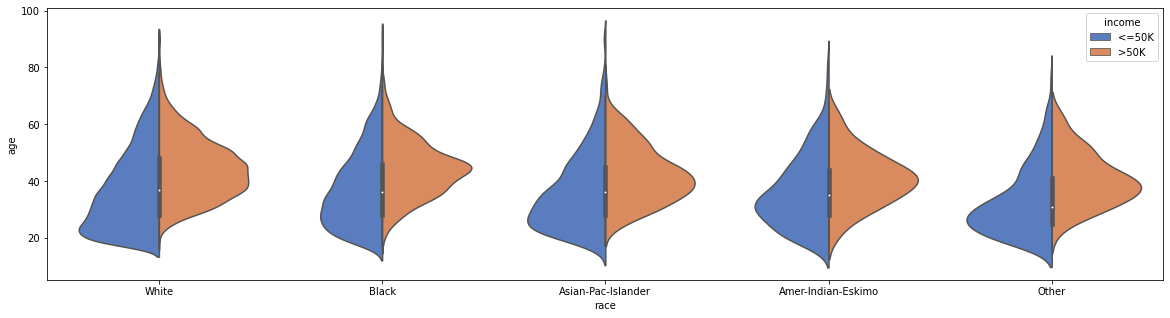

In [21]:
from matplotlib import pyplot
gdim = (20, 5)
fig, gx = pyplot.subplots(figsize=gdim)
gx = sns.violinplot(x="race", y="age", hue="income",
                    data=data_mixed, gridsize=200, palette="muted", split=True, saturation=0.75)
gx

✔ Income(<=50K) is 0  and 1 is Income(>50K). we see that the mean of each race is around 40 as age.

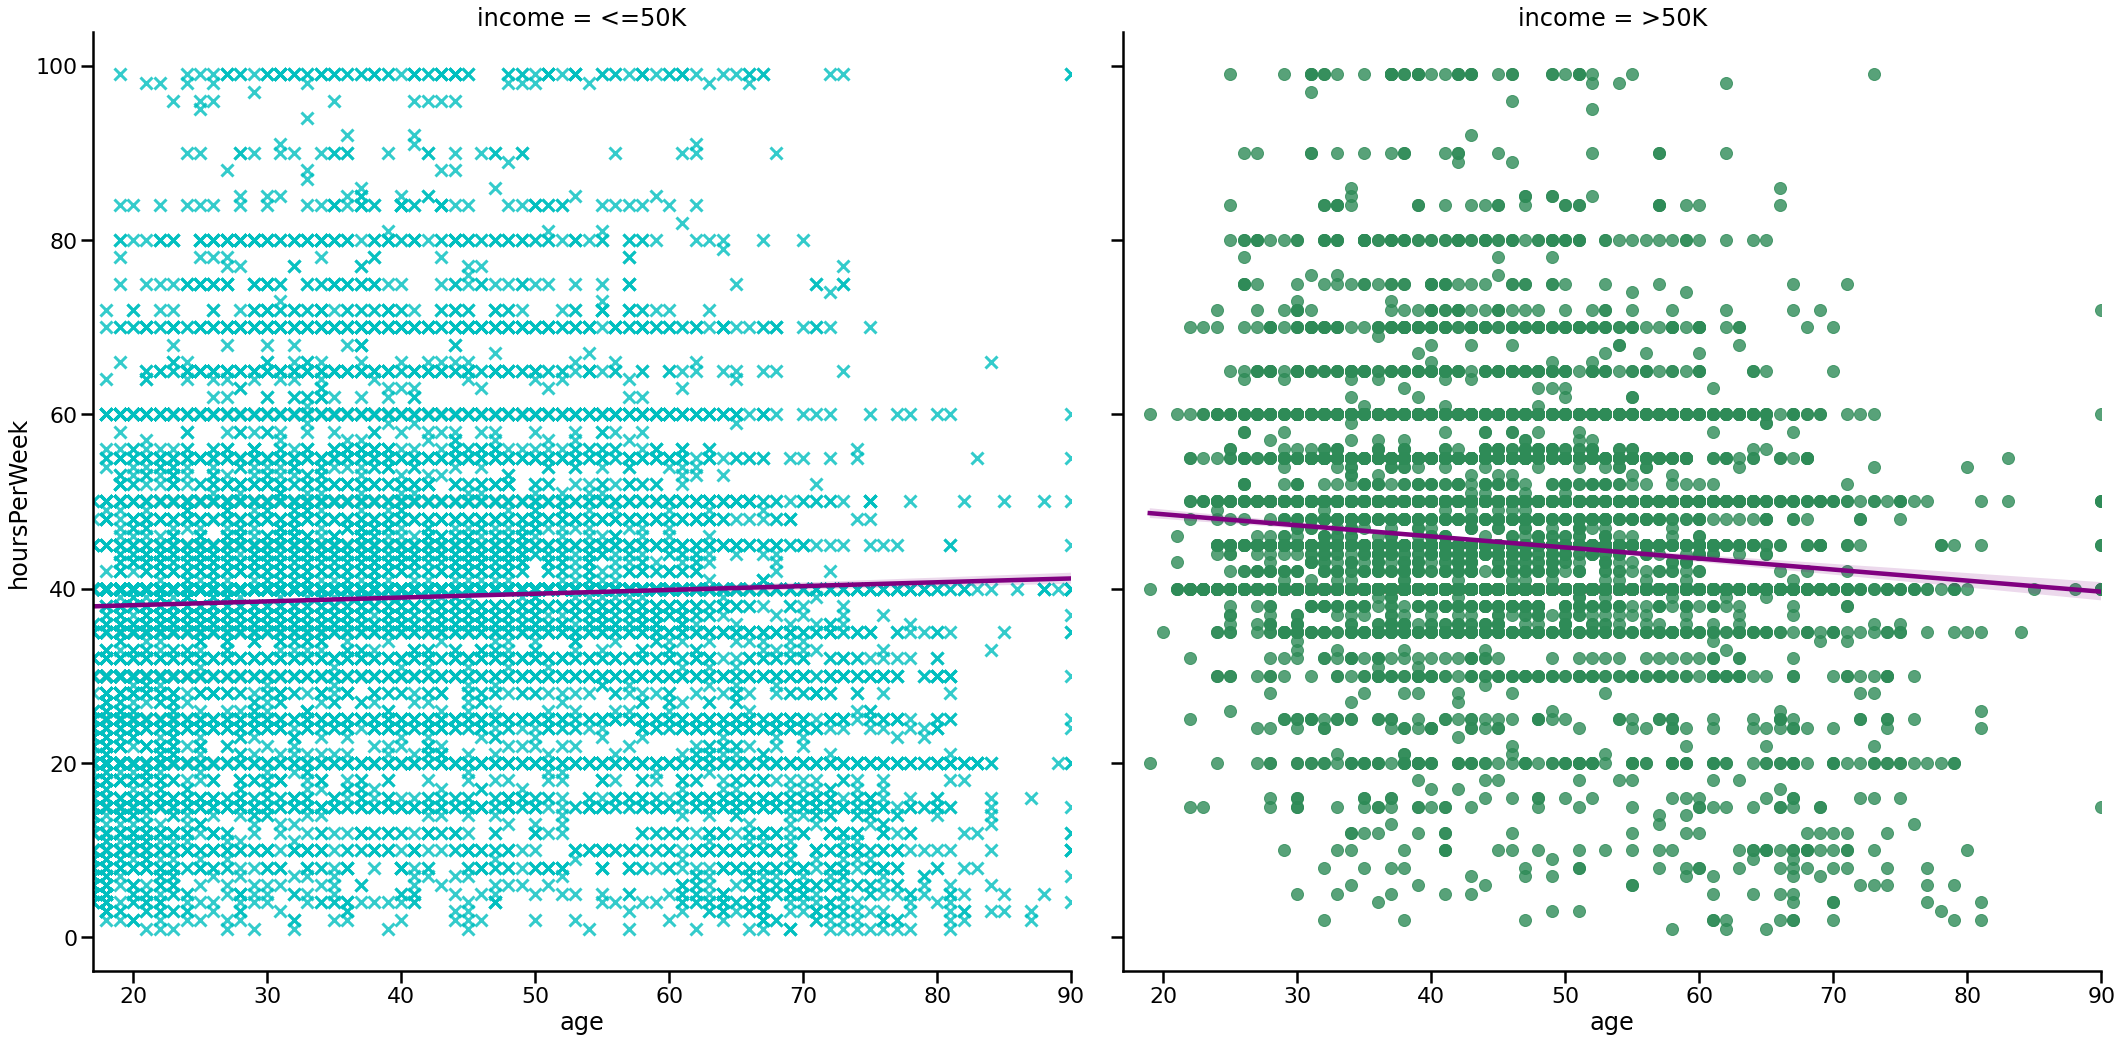

In [22]:
sns.set_context("poster")
eg=sns.lmplot(x="age",y='hoursPerWeek',hue='income',col="income",data=data_mixed, markers= ['x','o'],palette=["c",'seagreen'],height=15,line_kws={'color': 'purple'})

g= (g.set_axis_labels("Age","Hours Per Week"))

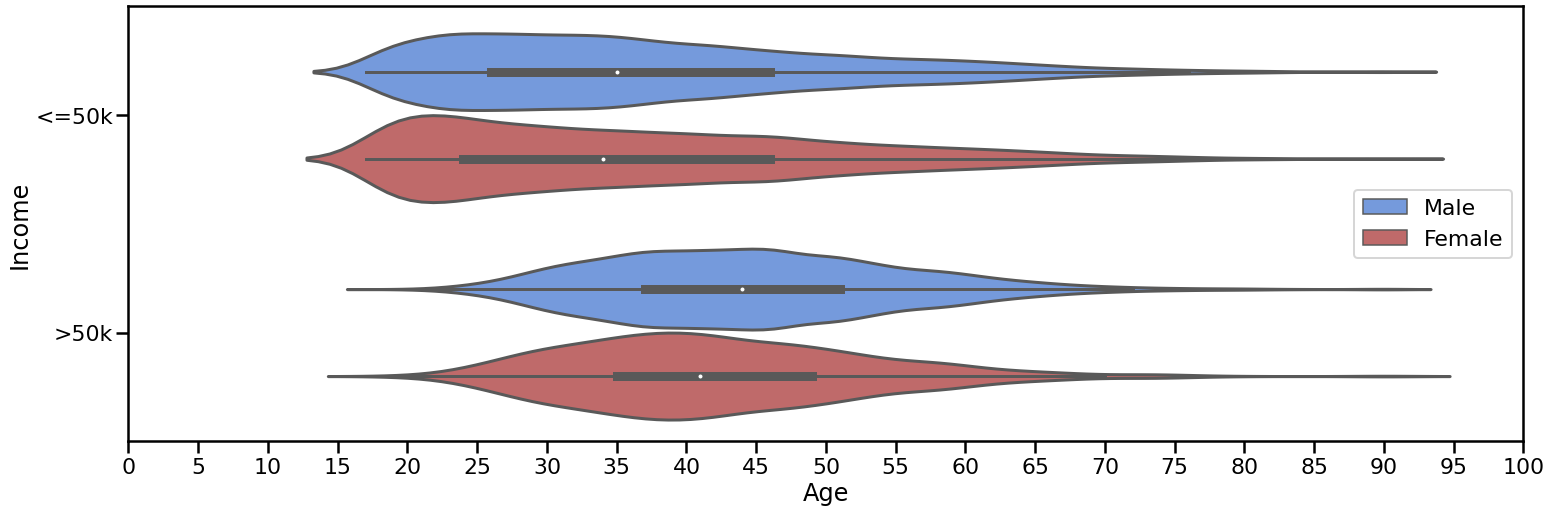

In [23]:
import matplotlib.ticker as ticker

fig, axe = plt.subplots(figsize=(25,8))
sns.set_context("poster")

g=sns.violinplot(x='age', y='income', hue='sex', hue_order=["Male","Female"], data=data_mixed, orient="h", palette=["cornflowerblue","indianred",])

g.set_ylabel("Income")
g.set_xlabel("Age")
g.set(yticklabels =['<=50k','>50k'])
setThis = g.legend(loc='center right')
plt.xlim(0,100)
axe.xaxis.set_major_locator(ticker.MultipleLocator(5))

This graph simply shows the correlation between 3 features namely Age and Income where its also visualize the feature Sex at the time. However it also shows a lost of correlation between sex and income.
It could mean that younger people, regardless of the gender, consistently earn less than their older counterparts. Therefore by deduction person's age has a significant im pact on earning income than gender.


CLASSIFICATION METHOD: Building our Models📚

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #❌
from sklearn import svm #support vector Machine   1
from sklearn.ensemble import RandomForestClassifier #2
from sklearn.linear_model import LogisticRegression # 3
from sklearn.ensemble import RandomForestClassifier # 4
from sklearn.tree import DecisionTreeClassifier # 5

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier  #6

In [25]:
# Feature Selection and Encoding
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 

In [26]:
data_mixed = data_mixed.apply(LabelEncoder().fit_transform)
data_mixed.tail()

,age,workclass,fnlwgt,education,educationNo,marital,occupation,relationship,race,sex,gain,loss,hoursPerWeek,country,income
16276,22,4,18319,9,12,0,10,1,4,0,0,0,35,39,0
16277,47,0,24787,11,8,6,0,2,2,1,0,0,39,39,0
16278,21,4,26541,9,12,2,10,0,4,1,0,0,49,39,0
16279,27,4,3833,9,12,0,1,3,1,1,82,0,39,39,0
16280,18,5,14059,9,12,2,4,0,4,1,0,0,59,39,1


In [27]:
"""Let drop some features before training / testing our data"""
features = ['education', 'country', 'income',]
y = data_mixed["income"]
X = data_mixed.drop(features, axis=1)

In [28]:
#training and testing data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [29]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# scale the numeric columns between 0 and 1 (normalization)
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns)
X_test = X_scaler.transform(X_test)

RANDOM FOREST MODEL

In [30]:
"""RANDOM FOREST MODEL"""
seed = np.random.randint(2**16)
model_rF = RandomForestClassifier(n_jobs=-1, random_state=seed)
model_rF.fit(X_train, y_train)
predicted = model_rF.predict(X_test)

"""Evaluation metrics"""
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

Test Accuracy: 85.69 %
F1 Score: 0.68


LOGISTIC REGRESSION MODEL

In [31]:
"""LOGISTIC REGRESSION MODEL"""
model_lR = LogisticRegression(random_state=seed)
model_lR.fit(X_train, y_train)
predicted = model_lR.predict(X_test)

"""Evaluation metrics"""
print("Test Accuracy:", format(metrics.accuracy_score(y_test, predicted) * 100, '.2f'), '%')
print("F1 Score:", format(metrics.f1_score(y_test, predicted), '.2f'))

Test Accuracy: 82.11 %
F1 Score: 0.56


GAUSSIAN NAIVE BAYES  

In [32]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB #Naive bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
score_gaussian = gaussian.score(X_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)

The accuracy of Gaussian Naive Bayes is 0.8176886068174839


K-NEAREST NEIGHBORS

In [33]:
from sklearn.neighbors import KNeighborsClassifier #KNN
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
#y_pred = knn.predict(X_test)
score_knn = knn.score(X_test,y_test)
print('The accuracy of the KNN Model is',score_knn)

The accuracy of the KNN Model is 0.8356024158050978


   XGBOOST 

In [34]:
#kfoldCV = StratifiedKFold(n_splits=5, random_state=0)
outcome = []
Modelnames = []  
models = []
kfoldCV = StratifiedKFold(n_splits=5, random_state=0)
xgb_model = XGBClassifier(n_estimators=250)
results = cross_val_score(xgb_model, X_train, y_train, cv=kfoldCV)
print("XGBClassifier: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
outcome.append(results)
Modelnames.append("XGBClassifier")
for name, model in models:
    kfoldCV = KFold(n_splits=5, random_state=0)
    cv_r = cross_val_score(model, X_train, y_train, cv=kfoldCV, scoring='accuracy')
    outcome.append(cv_r)
    Modelnames.append(name)
    print("%s: %.2f%% (%.2f%%)" % (name, cv_r.mean()*100, cv_r.std()*100))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBClassifier: 86.56% (0.31%)


Cross Validation

In [35]:
### Cross validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Naive Bayes','Logistic Regression','KNN','Random Forest', 'XGBoost']
models=[GaussianNB(),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),
        RandomForestClassifier(n_estimators=100), XGBClassifier(n_estimators=1600,learning_rate=0.05)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
models_dataframe

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

In

,CV Mean,Std
Naive Bayes,0.813214,0.003694
Logistic Regression,0.795033,0.005109
KNN,0.791020,0.003082
Random Forest,0.858380,0.004268
XGBoost,0.870624,0.004202


We obviously see that XGBoost is the most accurate.

In [ ]:
🎭🚀